In [ ]:
"""
    Ranking:
        1.1 Hierarchical Clustering (ranking_prediction.ipynb)
        1.2 Map labels to future matches as home and away of past season
            1.2.1 If team is new, label it as normal (which is a not promoted team)
        1.3 Compute difference in ranking (NO because of no sequential)
        1.4 Future work: study the week development of the league to see if there is a point where
            it can be started to predict the actual behavior of the team as the promotion label
    Prediction:
        2.0 Drop features --> computation differences (visualization.ipynb)
        2.1 Features TEST
            2.1.0 First match as median of past season (already started) TODO
            2.1.2 Median of current season (home and away games are definetely a factor)
            2.1.2.1 Median at home/away <-- Just this
            2.1.2.2 Past average of last n games (test with 3, 5, etc)
            2.1.2.3 Average of last n games at home/away
"""

In [318]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import playstyle
import pickle
import ranking
sns.set_style('darkgrid')

In [174]:
"""
    Everything to create the clusters
"""
from sklearn import preprocessing
from scipy.cluster.hierarchy import linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

# Returns Z, coph_matrix and best cophence score from HC
def HierarchicalClustering(data, label):
    methods = ["single","complete","average","centroid","ward"]

    # Pass the dataset into pdist to get your proximity matrix for calculating CPCC
    proximity_matrix = pdist(data)

    best_coph = -1
    best_method = None

    for method in methods:
        Z = linkage(data, method)
        coph, coph_matrix = cophenet(Z, proximity_matrix)
        if coph > best_coph:
            best_coph = coph
            best_method = method
            best_matrix = coph_matrix
        Z = linkage(data, best_method)
        coph_matrix = cophenet(Z)
    return Z, coph_matrix, best_coph

#Returns a dictionary with the clusters in the form
#"id": "season" : point -> Attr object
def dct_clusters(dct_clusters, Z, coph_matrix, dendo_label, criterion='distance', real=None):
    if real != None:
        clusters = real[0]
    else:
        clusters = fcluster(Z, t=coph_matrix[0], criterion=criterion)
    for i in range(0, len(dendo_label)):
        point = ranking.Attr(dendo_label[i], clusters[i])
        if point.value2 not in dct_clusters:
            dct_clusters[point.value2] = {}
            dct_clusters[point.value2][point.value3] = point
        else:
            dct_clusters[point.value2][point.value3] = point
    return dct_clusters, clusters

# Return the cluster of an specific type
def get_cluster_of_type(all_dct, country, league, seasons, target_col, clean_type, real=None):
    # Data initialization
    data, column_names = ranking.concat_data(country, league, seasons, target_col, clean_type)
    all_data, all_season, all_names, all_target = ranking.get_all_data(data, len(target_col))
    # Use Agglomerative
    all_data = preprocessing.StandardScaler().fit_transform(all_data)
    dendo_label = ranking.label_team_season(all_names, all_season)
    Z, coph_matrix, coph = HierarchicalClustering(all_data, dendo_label)
    if real == None:
        all_dct, all_lst = dct_clusters(all_dct, Z, coph_matrix, dendo_label)
    else:
        all_dct, all_lst = dct_clusters(all_dct, Z, coph_matrix, dendo_label, real=all_target)
    return all_dct

#Returns three clusters as: overall, home and away performance
def get_clusters(country, league, season, year_window=1):
    # Historicity: multi season directory
    start_season = season
    seasons = list(range(start_season, start_season - year_window, -1))
    seasons = sorted(seasons, reverse=True)
    # Targets
    target_col = ["rank", "points", "description"]
    # Gets the dictionary
    overall_dct = dict()
    home_dct = dict()
    away_dct = dict()
    real_dct = dict()
    for season in seasons:
        season = [season]
        real_dct = get_cluster_of_type(overall_dct, country, league, season, target_col, clean_type=None, real=True)
        overall_dct = get_cluster_of_type(overall_dct, country, league, season, target_col, clean_type=None)
        home_dct = get_cluster_of_type(home_dct, country, league, season, target_col, clean_type='home')
        away_dct = get_cluster_of_type(away_dct, country, league, season, target_col, clean_type='away')
    return (overall_dct, home_dct, away_dct, real_dct)

In [291]:
"""
    Creates the statistics dataset
"""
def get_statistics(country, league, curr_week, season, year_window=1):
    # Historicity: multi season directory
    start_season = season
    seasons = list(range(start_season-1, start_season - year_window, -1))
    seasons = sorted(seasons, reverse=True)
    # Data initialization
    data = []
    # Current week
    df, target = playstyle.df_season(country, league, season, curr_week, drop_goals=False)
    tup = (season, df, target)
    data.append(tup)
    # Past years
    for season in seasons:
        df, target = playstyle.df_season(country, league, season, 38, drop_goals=False)
        tup = (season, df, target)
        data.append(tup)
    all_data, all_target = playstyle.get_all(data)
    return all_data, all_target

In [4]:
"""
    Function that maps the dataset with the clusters
"""
def max_appearance_rank(dct, season):
    dct_rank = dict()
    season = str(int(season))
    for team in dct:
        if season in dct[team]:
            rank = dct[team][season].value
            if rank not in dct_rank:
                dct_rank[rank] = 1
            else:
                dct_rank[rank] += 1
    return max(dct_rank.keys(), key=dct_rank.get)

def get_rank(df, dct, team):
    rank = []
    for index, row in df.iterrows():
        season = row["season"]
        season = season - 1
        if str(row[team]) in dct:
            if str(season) in dct[str(row[team])]:
                rank.append(dct[str(row[team])][str(season)].value)
            else:
                max_appear = max_appearance_rank(dct, season)
                rank.append(max_appear)
        else:
            max_appear = max_appearance_rank(dct, season)
            rank.append(max_appear)
    return rank

def get_data(dct, statistics):
    statistics["home_team.overall_rank"] = get_rank(statistics, dct[0], "home_team.id")
    statistics["away_team.overall_rank"] = get_rank(statistics, dct[0], "away_team.id")
    statistics["home_team.ranking"] = get_rank(statistics, dct[1], "home_team.id")
    statistics["away_team.ranking"] = get_rank(statistics, dct[2], "away_team.id")
    statistics["home_team.real_rank"] = get_rank(statistics, dct[3], "home_team.id")
    statistics["away_team.real_rank"] = get_rank(statistics, dct[3], "away_team.id")
    return statistics, statistics["home_team.overall_rank"].values.reshape(-1, 1), statistics["away_team.overall_rank"].values.reshape(-1, 1), statistics["home_team.ranking"].values.reshape(-1, 1), statistics["away_team.ranking"].values.reshape(-1, 1),statistics["home_team.real_rank"].values.reshape(-1, 1), statistics["away_team.real_rank"].values.reshape(-1, 1)

In [5]:
def get_median(df, method=None, season=None, week=None):
    # GET median for team_home.stats_home. team_home.stats_away. team_away.stats_home. team_away.stats_away.
    # Filter df according to method
    if method == '1':
        print("Current and past season median")
        df = df[(df["season"].isin([season, season-1]))]
    elif method == '2':
        print("Current and all past seasons median")
        df = df[(df["season"] <= season)]
    elif method == '3':
        print("Current season only median")
        # First and second week zero/one home/away games
        if week > 3:
            df = df[(df["season"] == season)]
        else:
            df = df[(df["season"].isin([season, season-1]))]
    elif method == '4':
        print("Last 5 games median")
        if week > 5:
            weeks = [w for w in range(week-1, week-6, -1)]
            df = df[(df["season"] == season) & (df["week"].isin(weeks))]
        else:
            df = df[(df["season"].isin([season, season-1]))]
        
    # Median home
    extra_columns = df.filter(["goals_home"]).columns
    columns_home = df.filter(regex='^stats_home').columns
    columns_home = columns_home.append(extra_columns)
    median_home = df.groupby(['home_team.id'], as_index=True)[columns_home].median()
    # Median away
    extra_columns = df.filter(["goals_away"]).columns
    columns_away = df.filter(regex='^stats_away').columns
    columns_away = columns_away.append(extra_columns)
    median_away = df.groupby(['away_team.id'], as_index=True)[columns_away].median()
    if method == '5':
        print("Current season only mean")
        # First and second week zero/one home/away games
        if week > 3:
            df = df[(df["season"] == season)]
        else:
            df = df[(df["season"].isin([season, season-1]))]
        mean_home = df.groupby(['home_team.id'], as_index=True)[columns_home].mean()
        mean_away = df.groupby(['away_team.id'], as_index=True)[columns_away].mean()
        return mean_home, mean_away
    return median_home, median_away

In [6]:
def create_test_set(df, teams, season, week, pezzali=True, method=None, extras=None):
    columns_home = ["goals_home", "stats_home.c_red", "stats_home.s_total", "stats_home.s_off_g", "stats_home.s_on_g", "stats_home.s_in", 
                   "stats_home.saves", "stats_home.s_blocked", "stats_home.c_yellow", "stats_home.s_out"]
    columns_away = ["goals_away", "stats_away.c_red", "stats_away.s_total", "stats_away.s_off_g", "stats_away.s_on_g", "stats_away.s_in", 
                   "stats_away.saves", "stats_away.s_blocked", "stats_away.c_yellow", "stats_away.s_out"]
    columns = ["season", "week"]
    columns = columns_home + columns_away + columns
    columns_pezzali = columns
    
    if pezzali == False or method == '5' or extras == '4' or extras == '3':
        extra_columns = df.filter(["goals_home"]).columns
        columns_home = df.filter(regex='^stats_home').columns
        columns_home = columns_home.append(extra_columns)
        extra_columns = df.filter(["goals_away"]).columns
        columns_away = df.filter(regex='^stats_away').columns
        columns_away = columns_away.append(extra_columns)
        columns = columns_home.append(columns_away)
        
    
    test_set = pd.DataFrame(columns=columns)
    home_teams = [match[0] for match in teams]
    away_teams = [match[1] for match in teams]
    seasons = [season for i in range(0, len(teams))]
    weeks = [week for i in range(0, len(teams))]
    test_set["home_team.id"] = home_teams
    test_set["away_team.id"] = away_teams
    test_set["season"] = seasons
    test_set["week"] = weeks
    
    columns_home = test_set.filter(columns_home).columns
    columns_away = test_set.filter(columns_away).columns
    i_th = test_set.columns.get_loc("home_team.id")
    i_ta = test_set.columns.get_loc("away_team.id")
    
    median_home, median_away = get_median(df, method, season, week)

    for i in range(0, len(test_set)):
        for index, row in median_home.iterrows():
            if test_set.iloc[i,i_th] == index:
                for c in columns_home:
                    try:
                        i_c = test_set.columns.get_loc(c)
                        test_set.iloc[i,i_c] = row[c]
                    except:
                        print(index, c)
    for i in range(0, len(test_set)):
        for index, row in median_away.iterrows():
            if test_set.iloc[i,i_ta] == index:
                for c in columns_away:
                    try:
                        i_c = test_set.columns.get_loc(c)
                        test_set.iloc[i,i_c] = row[c]
                    except:
                        print(index, c)
    # For non existing teams (this means ascending teams filled with median of column)
    test_set = test_set.apply(lambda x: x.fillna(x.median()),axis=0)
    if method == '5':
        test_set = linear_reg(test_set, columns)
        if pezzali == True and extras == '1':
            return test_set[['week','season','away_team.id', 'home_team.id', 'goals_home', 'stats_home.s_off_g', 'stats_home.s_on_g', 'stats_home.s_in', 'stats_home.saves', 'stats_home.s_blocked', 'stats_home.c_yellow', 'stats_home.s_out', 'goals_away', 'stats_away.s_off_g', 'stats_away.s_on_g', 'stats_away.s_in', 'stats_away.saves', 'stats_away.s_blocked', 'stats_away.c_yellow', 'stats_away.s_out', 'stats_home.s_total', 'stats_away.s_total', 'stats_home.c_red']]
    return test_set

In [7]:
def target_no_negative(target):
    # Target must be nonegative
    for i in range(0, len(target)):
        if target[i] < 0:
            target[i] = 2
    return target

In [8]:
import random
from scipy.stats import chi2_contingency 
def chi_squared_clusters(df, target):
    columns = ["home_team.ranking", "away_team.ranking","home_team.overall_rank", "away_team.overall_rank","home_team.real_rank", "away_team.real_rank"]
    # Target must be nonegative
    target = target_no_negative(target)
    # Get daframe randoms
    indexes = [random.randint(0, 380) for x in range(0, 100)]
    for c in columns:
        col1 = [df[c].values[indexes[i]] for i in range(0, 100)]
        #col2 = [df[c[1]].values[indexes[i]] for i in range(0, 100)]
        test_target = [target[indexes[i]] for i in range(0, 100)]
        #diff = np.absolute(np.array(col1)-np.array(col2))
        data = [col1, test_target]
        stat, p, dof, expected = chi2_contingency(data)
        # interpret p-value 
        alpha = 0.05
        if p <= alpha: 
            print('Significant relation c = %s, p = %f' %(c, p)) 
        else: 
            print('Not significant c = %s, p = %f' %(c, p)) 

In [10]:
# For the linear regression model, loads pretrains and returns the prediction
def get_regression(row, column):
    global country
    # Load model
    filename = 'model/' + country + '/' + column + '.sav'
    model = pickle.load(open(filename, 'rb'))
    row = row.drop(column)
    row = row.drop("home_team.id")
    row = row.drop("away_team.id")
    row = row.drop("season")
    row = row.drop("week")  
    pred = np.array(row).reshape(1, -1)
    return model.predict(pred)

In [9]:
# Returns the test set for all columns calculating linear regression
def linear_reg(test_set, columns):
    for i in range(0, len(test_set)):
        for c in columns:
            try:
                i_c = test_set.columns.get_loc(c)
                test_set.iloc[i,i_c] = get_regression(test_set.iloc[i], c)
            except:
                print(i, c)
                raise
    return test_set

In [11]:
# Return the index for the confusion matrix
def get_index(label):
    if label == -1:
        return 2
    else:
        return label

In [142]:
"""
    A proper evaluation: we cannot test week 10 2018 with week 20 2018
    The sequence of events must be maintained
"""
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
 
def subtraining_testset(df, season, week):
    df_sub = df[(df["season"] == season) & (df["week"] < week)]
    
    if week < 3:
        df_past = df[(df["season"] == season-1)]
        df_sub = df_sub.append(df_past)
    
    return df_sub

def subtraining_trainset(df, season, week, up_to_season):
    df_sub = df[(df["season"] == season) & (df["week"] < week)]
    target = []
    past_seasons = [s for s in range(up_to_season, season)]
    
    df_past = df[(df["season"].isin(past_seasons))]
    
    df_sub = df_sub.append(df_past)
    
    for index, row in df_sub.iterrows():
        target.append(playstyle.get_status(row))
    
    return df_sub, target

def test_list(df, season, week):
    df_test = df[(df["season"] == season) & (df["week"] == week)]
    teams = []
    target = []
    for index, row in df_test.iterrows():
        teams.append([row["home_team.id"], row["away_team.id"]])
        target.append(playstyle.get_status(row))
    return teams, target


In [240]:
# Data found to be not relevant to models
# If not using Anova
def remove_before_models(df, extras, if_anova=False):
    if extras != '1':
        if not if_anova or if_anova == 'both':
            try:
                df = df.drop(columns=['stats_home.c_yellow', 'stats_away.c_yellow', 'stats_home.p_accurate','stats_away.p_accurate','stats_away.p_total','stats_away.fouls','stats_home.p_total','stats_home.fouls','stats_home.corners','stats_home.offside','stats_away.corners','stats_away.offside'], axis=1)
            except:
                print("NO")
        try:
            df = df.drop(columns=['index'], axis=1)
        except:
            print("")
        try:
            df = df.drop(columns=['stats_home','stats_away'], axis=1)
        except:
            print("")
    return df

In [312]:
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import RidgeClassifierCV

"""
    Multilabel learning with sci-kit
"""
def models_evaluation(train_set, target, test_set, test_target, accuracy_dct, total_tests, k_best=10, if_anova=False, clf_to_save='rforest'):
    total_tests = total_tests + len(test_target)
    print(total_tests)
    st = preprocessing.StandardScaler().fit_transform(train_set)
    sp = preprocessing.StandardScaler().fit_transform(test_set)
    # 1) anova filter, take n best ranked features
    anova_filter = SelectKBest(f_regression, k=k_best)
    classifiers = dict(nb_ovo=OneVsOneClassifier(GaussianNB()),
                       svc_ovo=OneVsOneClassifier(SVC(kernel='linear', probability=True)),
                       ridge=OneVsOneClassifier(RidgeClassifierCV(class_weight='balanced')), 
                       rforest=OneVsOneClassifier(RandomForestClassifier(random_state=0, criterion="entropy", max_features="log2", min_samples_leaf=2)))
    rfY = None
    for name, clf in classifiers.items():
        if if_anova or if_anova == 'both':
            anova_model = make_pipeline(anova_filter, clf)
        else:
            anova_model = clf
        anova_model.fit(st, target)
        Y = anova_model.predict(sp)
        if name == clf_to_save:
            rfY = Y
        for i in range(0, len(test_target)):
            i_predicted = get_index(Y[i])
            i_actual = get_index(test_target[i])
            accuracy_dct[name]["predicted"][i_actual][i_predicted] += 1
        accuracy_dct[name]["score"] += accuracy_score(test_target, Y, normalize=False)
    return accuracy_dct, total_tests, rfY

In [202]:
"""
    This function returns a training set with the given method
"""
def train_method(dct, train_set, s, w, seasons, method, extras=None, if_anova=False):
    print("Train Method")
    statistics_subset = None
    target = None
    if method == '1':
        print("Current and past season median")
    elif method == '2':
        print("Current and all past seasons median")
    elif method == '3':
        print("Current season only median")
    elif method == '4':
        print("Last 5 games median")
    elif method == '5':
        print("Current and past season linear regression")
    elif method == '6':
        print("Current and all past seasons linear regression")
    elif method == '7':
        print("Current season only linear regression")
    elif method == '8':
        print("Plain train set: all games from past seasons")
        statistics_subset, target = subtraining_trainset(train_set, s, w, seasons)
   
    # If something must be removed
    statistics_removed = remove_before_models(statistics_subset, extras, if_anova)
    n = 10
    if extras == '1':
        print("Applies pezzali to train set")
        statistics_subset = playstyle.pezzali_data(statistics_subset, is_train=True)
        statistics_subset,_,_,_,_,_,_ = get_data(dct, statistics_subset)
        statistics_subset = statistics_subset.drop(columns=['home_team.id', 'away_team.id', 'home_team.name', 'away_team.name', 'season', 'week'])
    elif extras == '2':
        print("Applies pca to train set")
        statistics_subset,ho,ao,hr,ar,rh,ra = get_data(dct, statistics_removed)
        statistics_subset = statistics_subset.drop(columns=['home_team.id', 'away_team.id', 'home_team.name', 'away_team.name', 'goals_away','goals_home','season','week'])
        pca = PCA(n_components=n)
        statistics_subset = pca.fit_transform(statistics_subset)
        statistics_subset = np.append(statistics_subset, ho, axis=1)
        statistics_subset = np.append(statistics_subset, ao, axis=1)
        statistics_subset = np.append(statistics_subset, hr, axis=1)
        statistics_subset = np.append(statistics_subset, ar, axis=1)
        statistics_subset = np.append(statistics_subset, rh, axis=1)
        statistics_subset = np.append(statistics_subset, ra, axis=1)
    elif extras == '3':
        print("Adds pezzali and then pca to train set")
        statistics_subset = playstyle.pezzali_data(statistics_removed, is_train=True, both=True)
        statistics_subset,ho,ao,hr,ar,rh,ra = get_data(dct, statistics_subset)
        statistics_subset = statistics_subset.drop(columns=['home_team.id', 'away_team.id', 'home_team.name', 'away_team.name', 'goals_away','goals_home','season','week'])
        pca = PCA(n_components=n)
        statistics_subset = pca.fit_transform(statistics_subset)
        statistics_subset = np.append(statistics_subset, ho, axis=1)
        statistics_subset = np.append(statistics_subset, ao, axis=1)
        statistics_subset = np.append(statistics_subset, hr, axis=1)
        statistics_subset = np.append(statistics_subset, ar, axis=1)
        statistics_subset = np.append(statistics_subset, rh, axis=1)
        statistics_subset = np.append(statistics_subset, ra, axis=1)
    elif extras == '4':
        print("Adds pezzali to plain train set")
        statistics_subset = playstyle.pezzali_data(statistics_removed, is_train=True, both=True)
        statistics_subset,ho,ao,hr,ar,rh,ra = get_data(dct, statistics_removed)
        statistics_subset = statistics_subset.drop(columns=['home_team.id', 'away_team.id', 'home_team.name', 'away_team.name', 'goals_away','goals_home','season','week'])
    elif extras == '0':
        print("Plain train set with clusters")
        statistics_subset,_,_,_,_,_,_ = get_data(dct, statistics_removed)
        statistics_subset = statistics_subset.drop(columns=['home_team.id', 'away_team.id','home_team.name', 'away_team.name','goals_away','goals_home','season','week'])
    return statistics_subset, target

In [201]:
def test_extras(dct, statistics_test, extras='0', if_anova=False):
    # If something must be removed
    statistics_removed = remove_before_models(statistics_test, extras, if_anova)
    n = 10
    if extras == '1':
        print("Applies pezzali to test set")
        # Get test pezalli and mappings
        statistics_test = playstyle.pezzali_data(statistics_test, is_train=False)
        statistics_test,_,_,_,_,_,_ = get_data(dct, statistics_test)
        try:
            statistics_test = statistics_test.drop(columns=['home_team.id', 'away_team.id', 'season','week'])
        except:
            print("")
    elif extras == '2':
        print("Applies pca to test set")
        statistics_test,ho,ao,hr,ar,rh,ra = get_data(dct, statistics_test)
        pca = PCA(n_components=n)
        statistics_test = pca.fit_transform(statistics_removed)
        statistics_test = np.append(statistics_test, ho, axis=1)
        statistics_test = np.append(statistics_test, ao, axis=1)
        statistics_test = np.append(statistics_test, hr, axis=1)
        statistics_test = np.append(statistics_test, ar, axis=1)
        statistics_test = np.append(statistics_test, rh, axis=1)
        statistics_test = np.append(statistics_test, ra, axis=1)
    elif extras == '3':
        print("Adds pezzali and then pca to test set")
        statistics_removed = playstyle.pezzali_data(statistics_removed, is_train=False, both=True)
        statistics_removed = statistics_removed.drop(columns=['home_team.id', 'away_team.id', 'goals_away','goals_home','season','week'])
        statistics_test,ho,ao,hr,ar,rh,ra = get_data(dct, statistics_test)
        pca = PCA(n_components=n)
        statistics_test = pca.fit_transform(statistics_removed)
        statistics_test = np.append(statistics_test, ho, axis=1)
        statistics_test = np.append(statistics_test, ao, axis=1)
        statistics_test = np.append(statistics_test, hr, axis=1)
        statistics_test = np.append(statistics_test, ar, axis=1)
        statistics_test = np.append(statistics_test, rh, axis=1)
        statistics_test = np.append(statistics_test, ra, axis=1)
    elif extras == '4':
        print("Adds pezzali to plain test set")
        statistics_removed = playstyle.pezzali_data(statistics_removed, is_train=False, both=True)
        statistics_removed = statistics_removed.drop(columns=['home_team.id', 'away_team.id', 'goals_away','goals_home','season','week'])
        statistics_test,ho,ao,hr,ar,rh,ra = get_data(dct, statistics_test)
        statistics_test = np.append(statistics_removed, ho, axis=1)
        statistics_test = np.append(statistics_test, ao, axis=1)
        statistics_test = np.append(statistics_test, hr, axis=1)
        statistics_test = np.append(statistics_test, ar, axis=1)
        statistics_test = np.append(statistics_test, rh, axis=1)
        statistics_test = np.append(statistics_test, ra, axis=1)
    elif extras == '0':
        print("Plain test set with clusters")
        statistics_test,_,_,_,_,_,_ = get_data(dct, statistics_removed)
        statistics_test = statistics_test.drop(columns=['home_team.id', 'away_team.id','goals_away','goals_home','season','week'])
    return statistics_test

In [300]:
"""
    This function returns a test set with the given method
"""
def test_method(dct, test_set, s, w, method, extras='0', if_anova=False):
    print("Test Method")
    teams, test_target = test_list(test_set, s, w)
    if extras == '2' or extras == '0':
        p = False
    else:
        p = True
    if 1 <= int(method) <= 4:
        statistics_test = create_test_set(test_set, teams, s, w, p, method, extras)
    elif method == '5':
        print("Current season only linear regression")
        statistics_test = create_test_set(test_set, teams, s, w, p, method, extras)
    
    statistics_test = test_extras(dct, statistics_test, extras, if_anova)
    
    return statistics_test, test_target

In [334]:
# This test is when testing against current season and previous seasons
def custom_test(clusters_dct, train_m, test_m, df, season, year_window=1, week=39, extras=None, k_best=10, if_anova=False, clf_to_save='rforest'):
    # Historicity: multi season directory
    start_season = season
    seasons = list(range(start_season, start_season - year_window, -1))
    seasons.reverse()
    # First row draws, second wins, third loses
    # Rows actual vs columns predicted
    accuracy_dct = {
        "nb":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "lreg":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "svc":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "rforest":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "nb_ovo":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "svc_ovo":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        },
        "ridge":{
            "score":0,
            "predicted":[[0,0,0],[0,0,0],[0,0,0]]
        }
    }
    total_tests = 0
    predicted_df = pd.DataFrame()
    for i in range(1, len(seasons)):
        # Test against 38 weeks
        s = seasons[i]
        if s != season:
            up_to_week = 39
        else:
            up_to_week = week
        for w in range(1, up_to_week):
            statistics_training, target = train_method(clusters_dct, df, s, w, seasons[0], train_m, extras, if_anova)
            statistics_predict, test_target = test_method(clusters_dct, df, s, w, test_m, extras, if_anova)
            accuracy_dct, total_tests, Y = models_evaluation(statistics_training, target, statistics_predict, test_target, accuracy_dct, total_tests, k_best, if_anova, clf_to_save)
            # The dataframe adding the prediction
            statistics_predict["season"] = [s for i in range(0, len(test_target))]
            statistics_predict["week"] = [w for i in range(0, len(test_target))]
            statistics_predict["target"] = test_target
            statistics_predict["predicted"] = Y
            predicted_df = predicted_df.append(statistics_predict, ignore_index=True)
    
    for clf in accuracy_dct:
        accuracy_dct[clf]["score"] = accuracy_dct[clf]["score"]/total_tests
    
    return accuracy_dct, predicted_df

In [242]:
def predict(df, clusters_dct, teams, season, week, test_m='1', extras='1', up_to_season=2017, classifier='rforest', if_anova=False, k_best=10):
    """
        teams: the list of pair of teams' ids as [[10, 20], [30, 20]]
    """
        
    classifiers = dict(nb_ovo=OneVsOneClassifier(GaussianNB()),
                       svc_ovo=OneVsOneClassifier(SVC(kernel='linear', probability=True)),
                       ridge=OneVsOneClassifier(RidgeClassifierCV(class_weight='balanced')), 
                       rforest=OneVsOneClassifier(RandomForestClassifier(random_state=0, criterion="entropy", max_features="log2", min_samples_leaf=2)))
    
    if extras == '2' or extras == '0':
        p = False
    else:
        p = True
        
    # Divide the training set to predict
    statistics_train, target = train_method(clusters_dct, df, season, week, up_to_season, method='8', extras=extras, if_anova=if_anova)
    # Creates the test set
    statistics_test = create_test_set(statistics_to_test, teams, season, week, p, test_m, extras)
    statistics_test = test_extras(clusters_dct, statistics_test, extras, if_anova)
    # Scale the training and test set
    st = preprocessing.StandardScaler().fit_transform(statistics_train)
    sp = preprocessing.StandardScaler().fit_transform(statistics_test)
    # Makes the prediction given a classifier
    # 1) anova filter, take n best ranked features
    if if_anova == True or if_anova == 'both':
        anova_filter = SelectKBest(f_regression, k=k_best)
        clf = make_pipeline(anova_filter, classifiers[classifier])
    else:
        clf = classifiers[classifier]
    clf.fit(st, target)
    Y = clf.predict(sp)
    return Y

In [233]:
def maps_results(teams, results, dct, season):
    for i in range(0, len(results)):
        home_team = dct[0][str(teams[i][0])][str(season)].name
        away_team = dct[0][str(teams[i][1])][str(season)].name
        print("home_team= %s, away_team= %s, result= %s" %(home_team, away_team, str(results[i])))

In [326]:
def stats_predictions(df):
    df["accurate"] = df["target"] == df["predicted"]
    df_ac = df[(df["accurate"] == True)]
    df_sw = pd.DataFrame()
    seasons = []
    week = []
    vals = []
    for k in df_ac.groupby(["season", "week"]).groups.keys():
        seasons.append(k[0])
        week.append(k[1])
    df_sw["season"] = seasons
    df_sw["week"] = week
    for row in df_ac.groupby(["season", "week"]).count().values:
        vals.append(row[0])
    df_sw["accurate"] = vals
    print("Total accurate = %s" % (str(len(df_ac))))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    sns.pointplot(data=df_sw, x="week", y="accurate", hue="season", style="season", palette="mako").set_title(country)

In [330]:
"""
    Everything to retrieve the data
"""
global country
country = 'ES'
league = '140'
curr_week = 5
season = 2020

# Dictionary for the clusters (clusters from 2016 - 2019)
dct = get_clusters(country, league, season, year_window=5)

# Dataframe for the match (test from 2017 to 2019)
statistics_to_test, target = get_statistics(country, league, curr_week, season, year_window=4)

In [331]:
up_to_season = 2020
year_window = 4 #2019 + 1
curr_week = 5
accuracy, df = custom_test(dct, '8', '1', statistics_to_test, up_to_season, year_window=year_window, week=curr_week, extras='0', clf_to_save='svc_ovo', if_anova='both')
print(accuracy)

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  7.0                 5.0             13.0               1.0   
1                  4.0                 3.0              9.0               2.0   
2                  5.0                 3.0              9.0               1.0   
3                  6.0                15.0             27.0               6.0   
4                  6.0                 6.0             18.0               6.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
32                 4.0                 8.0             13.0               1.0   
55                 8.0                10.0             22.0               4.0   
66                 9.0                12.0             25.0               4.0   
92                 6.0                 8.0             18.0               4.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
32                 4.0                 8.0             13.0               1.0   
55                 8.0                10.0             22.0               4.0   
66                 9.0                12.0             25.0               4.0   
92                 6.0                 8.0             18.0               4.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
16                 3.0                 6.0             13.0               4.0   
32                 4.0                 8.0             13.0               1.0   
42                 3.0                 4.0             11.0               4.0   
55                 8.0                10.0             22.0               4.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
16                 3.0                 6.0             13.0               4.0   
26                 2.0                 7.0             12.0               3.0   
32                 4.0                 8.0             13.0               1.0   
42                 3.0                 4.0             11.0               4.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
10                 1.0                 3.0             11.0               7.0   
16                 3.0                 6.0             13.0               4.0   
26                 2.0                 7.0             12.0               3.0   
32                 4.0                 8.0             13.0               1.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
10                 1.0                 3.0             11.0               7.0   
16                 3.0                 6.0             13.0               4.0   
19                 5.0                 8.0             14.0               1.0   
26                 2.0                 7.0             12.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
4                  7.0                11.0             26.0               8.0   
10                 1.0                 3.0             11.0               7.0   
16                 3.0                 6.0             13.0               4.0   
19                 5.0                 8.0             14.0               1.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
4                  7.0                11.0             26.0               8.0   
10                 1.0                 3.0             11.0               7.0   
16                 3.0                 6.0             13.0               4.0   
19                 5.0                 8.0             14.0               1.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
4                  7.0                11.0             26.0               8.0   
10                 1.0                 3.0             11.0               7.0   
12                 6.0                 5.0             18.0               7.0   
16                 3.0                 6.0             13.0               4.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
4                  7.0                11.0             26.0               8.0   
10                 1.0                 3.0             11.0               7.0   
12                 6.0                 5.0             18.0               7.0   
16                 3.0                 6.0             13.0               4.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
4                  7.0                11.0             26.0               8.0   
9                  4.0                14.0             23.0               5.0   
10                 1.0                 3.0             11.0               7.0   
12                 6.0                 5.0             18.0               7.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


   stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                7.5                 5.0             16.0               3.0   
1                3.5                 6.0             13.0               3.0   
2                4.0                 5.0             13.0               3.0   
3                4.0                 5.5             13.0               3.0   
4                5.0                 5.0             13.0               3.0   
5                5.0                 6.0             15.0               3.0   
6                4.0                 5.0             13.0               3.0   
7                5.0                 5.0             12.0               3.0   
8                4.0                 5.0             11.5               2.0   
9                4.0                 6.0             10.0               2.0   

   stats_home.s_total  stats_home.s_blocked  stats_home.possession  \
0                10.0                   5.5                 

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
9                  4.0                14.0             23.0               5.0   
10                 1.0                 3.0             11.0               7.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
9                  4.0                14.0             23.0               5.0   
10                 1.0                 3.0             11.0               7.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
9                  4.0                14.0             23.0               5.0   
10                 1.0                 3.0             11.0               7.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
9                  4.0                14.0             23.0               5.0   
10                 1.0                 3.0             11.0               7.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
9                  4.0                14.0             23.0               5.0   
10                 1.0                 3.0             11.0               7.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
9                  4.0                14.0             23.0               5.0   
10                 1.0                 3.0             11.0               7.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
9                  4.0                14.0             23.0               5.0   
10                 1.0                 3.0             11.0               7.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
9                  4.0                14.0             23.0               5.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


   stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                5.0                 5.5             13.5               3.0   
1                3.5                 6.0             13.0               3.0   
2                3.0                 5.0             12.0               3.0   
3                4.0                 5.0             13.0               3.0   
4                4.0                 5.5             12.5               2.0   
5                5.0                 6.0             15.0               3.0   
6                4.0                 5.0             13.0               3.0   
7                4.0                 5.0             12.5               2.0   
8                5.0                 5.5             14.5               3.0   
9                4.0                 6.0             10.0               2.0   

   stats_home.s_total  stats_home.s_blocked  stats_home.possession  \
0                 9.0                   5.5                 

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
9                  4.0                14.0             23.0               5.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
9                  4.0                14.0             23.0               5.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
9                  4.0                14.0             23.0               5.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
6                  6.0                 3.0             12.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
6                  6.0                 3.0             12.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
6                  6.0                 3.0             12.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
6                  6.0                 3.0             12.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
6                  6.0                 3.0             12.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
6                  6.0                 3.0             12.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
5                  9.0                 5.0             16.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
5                  9.0                 5.0             16.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


   stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                5.0                 5.5             13.5               3.0   
1                3.0                 5.0             12.0               3.0   
2                4.0                 5.0             13.0               3.0   
3                4.0                 5.5             12.5               2.0   
4                5.0                 6.0             15.0               3.0   
5                4.0                 5.0             13.0               3.0   
6                4.0                 5.0             12.5               2.0   
7                4.0                 6.0             13.0               3.0   
8                5.0                 5.5             14.5               3.0   
9                4.0                 6.0             10.0               2.0   

   stats_home.s_total  stats_home.s_blocked  stats_home.possession  \
0                 9.0                   5.5                 

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
5                  9.0                 5.0             16.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
1                  5.0                 2.0             11.0               4.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
1                  5.0                 2.0             11.0               4.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
1                  5.0                 2.0             11.0               4.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
1                  5.0                 2.0             11.0               4.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
1                  5.0                 2.0             11.0               4.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  1.0                 1.0              3.0               1.0   
1                  5.0                 2.0             11.0               4.0   
2                  7.0                 3.0             16.0               6.0   
3                  8.0                 3.0             13.0               2.0   
4                  7.0                11.0             26.0               8.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
3                  7.0                 3.0             12.0               2.0   
25                 3.0                10.0             15.0               2.0   
39                 6.0                 4.0             14.0               4.0   
69                 4.0                 5.0             13.0               4.0   
144                2.0                 6.0              9.0               1.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
3                  7.0                 3.0             12.0               2.0   
25                 3.0                10.0             15.0               2.0   
26                 4.0                 5.0             12.0               3.0   
39                 6.0                 4.0             14.0               4.0   
69                 4.0                 5.0             13.0               4.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
3                  7.0                 3.0             12.0               2.0   
10                 5.0                 3.0             10.0               2.0   
25                 3.0                10.0             15.0               2.0   
26                 4.0                 5.0             12.0               3.0   
39                 6.0                 4.0             14.0               4.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
3                  7.0                 3.0             12.0               2.0   
10                 5.0                 3.0             10.0               2.0   
24                 1.0                 7.0             10.0               2.0   
25                 3.0                10.0             15.0               2.0   
26                 4.0                 5.0             12.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
3                  7.0                 3.0             12.0               2.0   
8                  6.0                 5.0             18.0               7.0   
10                 5.0                 3.0             10.0               2.0   
24                 1.0                 7.0             10.0               2.0   
25                 3.0                10.0             15.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
3                  7.0                 3.0             12.0               2.0   
8                  6.0                 5.0             18.0               7.0   
10                 5.0                 3.0             10.0               2.0   
22                 3.0                 3.0              9.0               3.0   
24                 1.0                 7.0             10.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
3                  7.0                 3.0             12.0               2.0   
8                  6.0                 5.0             18.0               7.0   
10                 5.0                 3.0             10.0               2.0   
14                10.0                 4.0             17.0               3.0   
22                 3.0                 3.0              9.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
3                  7.0                 3.0             12.0               2.0   
8                  6.0                 5.0             18.0               7.0   
10                 5.0                 3.0             10.0               2.0   
14                10.0                 4.0             17.0               3.0   
22                 3.0                 3.0              9.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
3                  7.0                 3.0             12.0               2.0   
8                  6.0                 5.0             18.0               7.0   
10                 5.0                 3.0             10.0               2.0   
14                10.0                 4.0             17.0               3.0   
22                 3.0                 3.0              9.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
8                  6.0                 5.0             18.0               7.0   
10                 5.0                 3.0             10.0               2.0   
14                10.0                 4.0             17.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
8                  6.0                 5.0             18.0               7.0   
10                 5.0                 3.0             10.0               2.0   
14                10.0                 4.0             17.0               3.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


   stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                5.0                 5.0             13.0               3.0   
1                4.0                 6.0             11.0               2.0   
2                4.0                 5.0             12.0               3.0   
3                4.0                 5.0             13.0               2.5   
4                4.0                 4.0             12.0               3.0   
5                5.0                 6.5             15.0               3.0   
6                3.0                 5.0             12.0               2.0   
7                7.0                 6.0             17.0               3.0   
8                4.0                 5.0             10.0               2.0   
9                5.0                 6.0             14.0               3.0   

   stats_home.s_total  stats_home.s_blocked  stats_home.possession  \
0                 9.0                   4.0                 

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
8                  6.0                 5.0             18.0               7.0   
9                  7.0                 3.0             11.0               1.0   
10                 5.0                 3.0             10.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


   stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                5.0                 5.0             13.0               3.0   
1                5.0                 5.0             14.0               3.5   
2                4.0                 6.0             11.0               2.0   
3                5.0                 5.0             14.0               3.0   
4                4.0                 5.0             12.0               3.0   
5                4.0                 5.0             13.0               2.5   
6                3.0                 5.0             12.0               2.0   
7                7.0                 6.0             17.0               3.0   
8                4.0                 5.0             10.0               2.0   
9                5.0                 6.0             14.0               3.0   

   stats_home.s_total  stats_home.s_blocked  stats_home.possession  \
0                 9.0                   4.0                 

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
5                  1.0                12.0             15.0               2.0   
8                  6.0                 5.0             18.0               7.0   
9                  7.0                 3.0             11.0               1.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
5                  1.0                12.0             15.0               2.0   
8                  6.0                 5.0             18.0               7.0   
9                  7.0                 3.0             11.0               1.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
8                  6.0                 5.0             18.0               7.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
8                  6.0                 5.0             18.0               7.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
8                  6.0                 5.0             18.0               7.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
8                  6.0                 5.0             18.0               7.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
6                  5.0                12.0             21.0               4.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
6                  5.0                12.0             21.0               4.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0  

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters


/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0                 5.0             11.0               0.0   
379                5.0                 5.0             14.0               4.0   

     stats_home.s_total  st

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
5                  1.0                12.0             15.0               2.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
2                  4.0                12.0             17.0               1.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
2                  4.0                12.0             17.0               1.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
2                  4.0                12.0             17.0               1.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
2                  4.0                12.0             17.0               1.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
2                  4.0                12.0             17.0               1.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
2                  4.0                12.0             17.0               1.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

/anaconda3/envs/thesis/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
0                  4.0                 2.0              9.0               3.0   
1                  8.0                 5.0             19.0               6.0   
2                  4.0                12.0             17.0               1.0   
3                  7.0                 3.0             12.0               2.0   
4                  3.0                10.0             23.0              10.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
3                  4.0                 7.0             15.0               4.0   
5                  8.0                 4.0             14.0               2.0   
10                 2.0                 2.0              4.0               0.0   
13                 3.0                 7.0             12.0               2.0   
17                 0.0                 0.0              0.0               0.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
2                  8.0                 6.0             14.0               0.0   
3                  4.0                 7.0             15.0               4.0   
5                  8.0                 4.0             14.0               2.0   
9                  6.0                 6.0             16.0               4.0   
10                 2.0                 2.0              4.0               0.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

Train Method
Plain train set: all games from past seasons

Plain train set with clusters
Test Method
Current and past season median

Plain test set with clusters
     stats_home.s_on_g  stats_home.s_off_g  stats_home.s_in  stats_home.s_out  \
1                  2.0                 2.0              5.0               1.0   
2                  8.0                 6.0             14.0               0.0   
3                  4.0                 7.0             15.0               4.0   
5                  8.0                 4.0             14.0               2.0   
6                  2.0                 2.0              5.0               1.0   
..                 ...                 ...              ...               ...   
375                6.0                 4.0             15.0               5.0   
376                3.0                11.0             16.0               2.0   
377                6.0                 5.0             18.0               7.0   
378                6.0      

{'nb': {'score': 0.0, 'predicted': [[0, 0, 0], [0, 0, 0], [0, 0, 0]]}, 'lreg': {'score': 0.0, 'predicted': [[0, 0, 0], [0, 0, 0], [0, 0, 0]]}, 'svc': {'score': 0.0, 'predicted': [[0, 0, 0], [0, 0, 0], [0, 0, 0]]}, 'rforest': {'score': 0.4504391468005019, 'predicted': [[42, 133, 52], [54, 241, 60], [37, 102, 76]]}, 'nb_ovo': {'score': 0.46800501882057716, 'predicted': [[5, 181, 41], [8, 300, 47], [9, 138, 68]]}, 'svc_ovo': {'score': 0.46925972396486826, 'predicted': [[34, 136, 57], [39, 257, 59], [31, 101, 83]]}, 'ridge': {'score': 0.4228356336260979, 'predicted': [[93, 82, 52], [129, 167, 59], [79, 59, 77]]}}


In [332]:
df.head()

,stats_home.s_on_g,stats_home.s_off_g,stats_home.s_in,stats_home.s_out,stats_home.s_total,stats_home.s_blocked,stats_home.possession,stats_home.c_red,stats_home.saves,stats_home.p_percentage,...,home_team.overall_rank,away_team.overall_rank,home_team.ranking,away_team.ranking,home_team.real_rank,away_team.real_rank,season,week,target,predicted
0,5.0,5.0,14.0,3.0,8.5,5.0,0.530,0.0,2.0,0.807978,...,2,2,1,3,2,2,2018,1,-1,1
1,5.0,5.5,13.5,3.0,9.0,5.5,0.495,0.0,3.0,0.818749,...,2,2,1,3,2,2,2018,1,0,1
2,4.5,5.0,13.0,3.0,8.0,5.0,0.595,0.0,2.5,0.863650,...,2,2,1,3,2,2,2018,1,-1,1
3,7.5,5.0,16.0,3.0,10.0,5.5,0.620,0.0,2.0,0.877255,...,2,2,1,3,2,2,2018,1,1,1
4,4.5,6.5,14.0,3.0,9.0,5.0,0.550,0.0,2.0,0.728810,...,2,2,1,3,2,2,2018,1,-1,1


Total accurate = 374


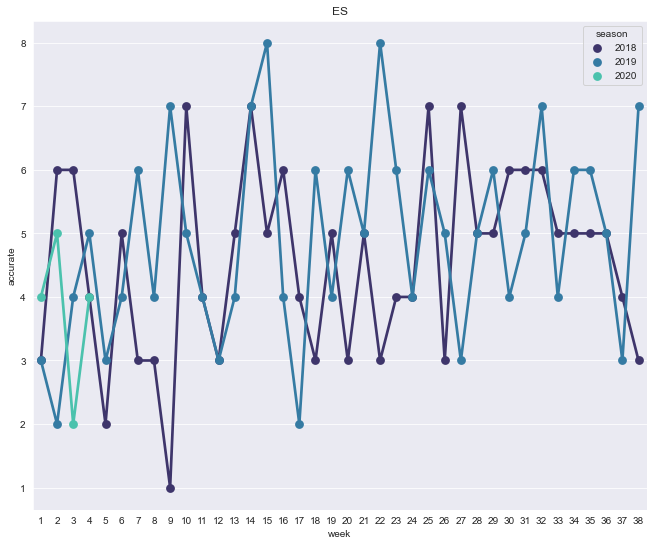

In [333]:
stats_predictions(df)

In [323]:
"""
    Everything to retrieve the data
"""
global country
country = 'ES'
league = '140'
curr_week = 5
season = 2020

# Dictionary for the clusters (clusters from 2016 - 2019)
dct = get_clusters(country, league, season, year_window=5)

# Dataframe for the match (test from 2017 to 2019)
statistics_to_test, target = get_statistics(country, league, curr_week, season, year_window=4)

In [325]:
# TODO: MAP clusters on current season
teams = [[542, 797], [531, 539], [543, 548], [538, 530], [545, 727], [546, 529], [715, 536], [726, 720], [541, 724], [533, 532]]
season = 2020
week = 6
results = predict(statistics_to_test, dct, teams, season, week, test_m='3', extras='1', if_anova='both', classifier='ridge')
maps_results(teams, results, dct, season)

Train Method
Plain train set: all games from past seasons
Applies pezzali to train set
Current season only median
Applies pezzali to test set
home_team= Alaves - 2020, away_team= Elche - 2020, result= -1
home_team= Athletic Club - 2020, away_team= Levante - 2020, result= -1
home_team= Real Betis - 2020, away_team= Real Sociedad - 2020, result= 0
home_team= Celta Vigo - 2020, away_team= Atletico Madrid - 2020, result= 1
home_team= Eibar - 2020, away_team= Osasuna - 2020, result= 0
home_team= Getafe - 2020, away_team= Barcelona - 2020, result= 1
home_team= Granada CF - 2020, away_team= Sevilla - 2020, result= 1
home_team= Huesca - 2020, away_team= Valladolid - 2020, result= 1
home_team= Real Madrid - 2020, away_team= Cadiz - 2020, result= 0
home_team= Villarreal - 2020, away_team= Valencia - 2020, result= 1


In [ ]:
# Chi-squared test for clusters
chi_df,_,_,_,_,_,_ = get_data(dct, statistics_to_test)
chi_squared_clusters(chi_df, target)

In [ ]:
"""
    TODOs
    Test set: checar mean, checar mean/median en un intervalo de 5 partidos
    Train set: checar todas las diferencias, 
"""

In [ ]:
# Testing set to predict
# Creating fake records
teams = [[545, 538], [715, 531], [724, 727], [542, 543], [720, 548], [533, 726], [532, 539]]
season = 2020
week = 1
statistics_test = create_test_set(statistics_to_test, teams, season, week)
# Calculating pezzali score
test_pezzali = playstyle.pezzali_data(statistics_test, is_train=False)
# 1. Predicting with clusters of last season
test_pezzali.head()

In [ ]:
statistics_predict = get_data(dct, test_pezzali)

In [ ]:
statistics_predict

In [ ]:
st = remove_before_models(statistics_training)
sp = remove_before_models(statistics_predict, is_train=False)

In [ ]:
from scipy import stats
# Downsampling TODO
for c in st.columns:
    shapiro_test = stats.shapiro(st[c])
    print("column = %s \t statistic = %f pvalue = %f" %(c,shapiro_test.statistic, shapiro_test.pvalue))

In [ ]:
for c in sp.columns:
    shapiro_test = stats.shapiro(sp[c])
    print("column = %s \t statistic = %f pvalue = %f" %(c,shapiro_test.statistic, shapiro_test.pvalue))

In [ ]:
st = preprocessing.StandardScaler().fit_transform(st)
sp = preprocessing.StandardScaler().fit_transform(sp)
sv_p = SVC(kernel='linear', probability=True)
sv_p.fit(st, target)
print(sv_p.predict(sp))

In [ ]:
# using scaler on nb
from sklearn.naive_bayes import GaussianNB
sv_p = SVC(kernel='linear', probability=True)
sv_p.fit(st, target)
print(sv_p.predict(sp))

In [ ]:
from sklearn import linear_model
ols = linear_model.LogisticRegression()
ols.fit(st, target)
print(ols.predict(sp))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# At least two matches en each classification per week
premise_clf = RandomForestClassifier(criterion="entropy", max_features="log2", min_samples_leaf=2).fit(st, target)
print(premise_clf.predict(sp))

In [12]:
# Replaced by One vs One
def balance_dataset(dataset, target, draw=False):
    if draw:
        dataset = pd.DataFrame(dataset)
        dataset["target"] = target
        dataset = dataset[(dataset["target"] != 1)]
        new_target = np.array(dataset["target"])
        dataset = dataset.drop(columns=["target"], axis=1)
        for i in range(0, len(new_target)):
            if new_target[i] == 0:
                new_target[i] = 1
            elif new_target[i] == -1:
                new_target[i] = 0
        return dataset, new_target
    else:
        new_target = []
        for i in range(0, len(target)):
            if target[i] != 1:
                new_target.append(0)
            else:
                new_target.append(1)
        return dataset, new_target

In [135]:
# Replaced by One vs One
def models_evaluation(train_set, target, test_set, test_target, accuracy_dct, total_tests, k_best=10):
    total_tests = total_tests + len(test_target)
    print(total_tests)
    st = preprocessing.StandardScaler().fit_transform(train_set)
    sp = preprocessing.StandardScaler().fit_transform(test_set)
    # 1) anova filter, take n best ranked features
    anova_filter = SelectKBest(f_regression, k=k_best)
    classifiers = dict(nb=GaussianNB(), svc=SVC(kernel='linear', probability=True), lreg=linear_model.LogisticRegression(max_iter=1000), rforest=RandomForestClassifier(criterion="entropy", max_features="log2", min_samples_leaf=2))
    for name, clf in classifiers.items():
        #anova_model = make_pipeline(anova_filter, clf)
        anova_model = clf
        victory_dataset, victory_target = balance_dataset(st, target)
        draw_dataset, draw_target = balance_dataset(st, target, draw=True)
        # WITH VICTORIES
        anova_model.fit(victory_dataset, victory_target)
        Y_victory = anova_model.predict(sp)
        # WITH DRAWS
        anova_model.fit(draw_dataset, draw_target)
        Y_draw = anova_model.predict(sp)
        Y = []
        for i in range(0, len(Y_victory)):
            if Y_victory[i] == 0:
                if Y_draw[i] == 1:
                    Y.append(0)
                # Not a draw, then a loose
                else:
                    Y.append(-1)
            else:
                Y.append(1)
        #anova_model.fit(st, target)
        #Y = anova_model.predict(sp)
        #print(name)
        #print(Y)
        #print(test_target)
        #print(accuracy_score(test_target, Y, normalize=False))
        for i in range(0, len(test_target)):
            i_predicted = get_index(Y[i])
            i_actual = get_index(test_target[i])
            accuracy_dct[name]["predicted"][i_actual][i_predicted] += 1
        accuracy_dct[name]["score"] += accuracy_score(test_target, Y, normalize=False)
    return accuracy_dct, total_tests